# Initialization

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt

# Weight initialization via memristor model
def Vt2G_zeroDiagEP_wireR(Vg, Vt, C=1/7*25.2e-15, Rwire=0, mu=300/1e4, SS=0.14, Lg=1.2e-6):
    def update_element(i, j):
        delta_V = Vg - Vt[i, j]
        result = np.zeros_like(delta_V, dtype=float)
        
        # 1T1R parameters
        mask1 = delta_V >= 0.1
        result[mask1] = 1 / (1 / (C * mu / Lg ** 2 * delta_V[mask1] ) + Rwire * (i[mask1] + j[mask1]))

        mask2 = (delta_V > 0) & (delta_V < 0.1)
        result[mask2] = 1 / (1 / (0.1 * C * mu / Lg**2 * 2**((delta_V[mask2] - 0.1) / 0.1)) + Rwire * (i[mask2] + j[mask2]))
        
        mask3 = delta_V <= 0
        result[mask3] = 1/ ( 1 / ( 0.1 * C * mu / 2 / Lg ** 2 * 10 ** (( delta_V[mask3] ) / SS )) + Rwire * (i[mask3] + j[mask3])) 
        return result

    ranges = [ # 1-16-32-1 DNN with 3 bias = 53x53
        (range(0, 2), range(2, 18)),
        (range(2, 18), range(0, 2)),
        (range(2, 19), range(19, 51)),
        (range(19, 51), range(2, 19)),
        (range(19, 52), range(52, 53)),
        (range(52, 53), range(19, 52))
    ]

    out = np.zeros_like(Vt, dtype=float)

    for i_range, j_range in ranges:
        i_indices, j_indices = np.meshgrid(i_range, j_range, indexing='ij')
        i_indices = i_indices.flatten()
        j_indices = j_indices.flatten()
        out[i_indices, j_indices] = update_element(i_indices, j_indices)

    return  np.round(out, 10)

# ReLU activation 
def ReLU(x):
    return np.where(x > 0, x, 0)

# S1 initialization
def decide_s1(kk):
    global A, S
    s_select = S[np.searchsorted(A, kk)]
    return s_select

# Inference (for all possible states S1)
def RMAB_test():
    input_fixed = np.array([sigmoidShift] * matrix_size).reshape(-1).astype('float32') # Input vector reference
    TotalBatchCounter = 0
    Whittle_recorded = []
    NumBatch_test = 20 # For all states (1~20)
    s1_recorded = []
    for i in  range(1, NumBatch_test+1):
        TotalBatchCounter = TotalBatchCounter + 1
        s1 = (i) / 20 # Normalized from 1~20 to 0.05~1
        s1_recorded.append(s1)
        input_fixed[0] = s1 # Forward input scalar value
        input_fixed[matrix_size-52] = input_fixed[matrix_size-35] = input_fixed[matrix_size-2] = 0.05 # Bias
        input = copy.deepcopy(np.array([input_fixed])).reshape(-1)
        input4Whittle_recorded = [input - sigmoidShift]
        for k in range(1, cycle+1):
            initial_Pos = Vt2G_zeroDiagEP_wireR(0, VtMatrix_Pos)
            initial_Neg = Vt2G_zeroDiagEP_wireR(0, VtMatrix_Neg)
            for j in column_ranges
                    dudt = np.dot(ReLU(input - sigmoidShift), (initial_Pos[:, j] - initial_Neg[:, j])) # MVM
                    input[j] += dudt * dt
            input4Whittle_recorded.append(input - sigmoidShift)
        Whittle=np.dot(ReLU(input-sigmoidShift),(initial_Pos[:,matrix_size-1]-initial_Neg[:,matrix_size-1])) 
        Whittle_recorded.append(Whittle) 
        
    return Whittle_recorded

In [2]:
# RMAB parameters
matrix_size = 53
np.random.seed(123456) 
sigma_PGM = 0.1
RTN = 21e-3 
Vg = 0
NumBatch = 50 
NumEpisodes = 5
Timesteps = 20
cycle = 10
learningrate = 20e-5 
nudging = 0.01 

den = (2.0 ** np.arange(1, 21)).sum()
A = [(2.0 ** np.arange(1, 1 + i)).sum() / den for i in range(1, 21)]
S = [i / 20 for i in range(1, 21)]

m = 5
beta = 0.99
sigmoidSharpness = 0.1
dt = 450 
zmax = 20 

# column ranges are used for the desired input to three weights
column_ranges = [
    range(matrix_size - 51, matrix_size - 35),
    range(matrix_size - 34, matrix_size - 2),
    range(matrix_size - 1, matrix_size)
]

TotalBatchCounter=0
input_recorded=np.zeros((11,53))
matrix_size = 53
sigmoidShift = 0.0

Whittle_all_recorded = np.zeros([10,NumBatch,20])
arm = 0
# Initialization
connection_ideal_pos = np.random.normal(0, sigma_PGM, size=(53, 53))
connection_ideal_neg = np.random.normal(0, sigma_PGM, size=(53, 53))

# Training

In [3]:
# Weight matrix
W_trained = np.zeros((10,NumBatch,matrix_size,matrix_size))

# For all 10 arms,
for condition in ['A','B','C','D','E','F','G','H','I','J']:
    print('Arm ', condition)
    VtMatrix_Pos = copy.deepcopy(connection_ideal_pos)
    VtMatrix_Neg = copy.deepcopy(connection_ideal_neg)
    Pos_recorded = Neg_recorded = np.zeros((NumBatch+1,matrix_size,matrix_size))
    activation_recorded = np.zeros((NumBatch*NumEpisodes,Timesteps+4))
    s1_recorded = np.zeros((NumBatch*NumEpisodes,Timesteps))

    Pos_recorded[0,:,:] = VtMatrix_Pos
    Neg_recorded[0,:,:] = VtMatrix_Neg

    if condition == "A":
        theta0 = 10
        theta1 = 0.2
    elif condition == "B":
        theta0 = 8.5
        theta1 = 0.4
    elif condition == "C":
        theta0 = 7
        theta1 = 0.6
    elif condition == "D":
        theta0 = 5.5
        theta1 = 1
    elif condition == "E":
        theta0 = 10.5
        theta1 = 0.15
    elif condition == "F":
        theta0 = 9
        theta1 = 0.35
    elif condition == "G":
        theta0 = 7.5
        theta1 = 0.55
    elif condition == "H":
        theta0 = 6
        theta1 = 0.5
    elif condition == "I":
        theta0 = 9.5
        theta1 = 0.25
    elif condition == "J":
        theta0 = 8
        theta1 = 0.45
    else:
        print("Invalid")

    input_fixed = np.array([sigmoidShift] * matrix_size).reshape(-1).astype('float32')
    saved_variables = []

    W_Pos_init = Vt2G_zeroDiagEP_wireR(0, VtMatrix_Pos + np.random.normal(0, RTN, size=(matrix_size, matrix_size)))
    W_Neg_init = Vt2G_zeroDiagEP_wireR(0, VtMatrix_Neg + np.random.normal(0, RTN, size=(matrix_size, matrix_size)))

    # Training
    activation_value_recorded = np.zeros((NumBatch,NumEpisodes,Timesteps))
    Lambda_value_recorded = np.zeros((NumBatch,NumEpisodes,Timesteps))
    for b in range(1, NumBatch+1):
        TotalBatchCounter=TotalBatchCounter+1
        # s0 determined
        s0 = np.round(float(np.random.rand(1)) * zmax + 0.5) / 20

        input_fixed[0] = s0
        input_fixed[matrix_size-52] = input_fixed[matrix_size-35] = input_fixed[matrix_size-2] = 0.05 ## bias
        input = copy.deepcopy(np.array([input_fixed])).reshape(-1)
        input4Lambda_recorded=np.zeros((cycle+1,matrix_size))
        input4Lambda_recorded[0,:]=ReLU(input-sigmoidShift)

        for k in range(1, cycle+1):
            initial_Pos = Vt2G_zeroDiagEP_wireR(0, VtMatrix_Pos + np.random.normal(0, RTN, size=(matrix_size, matrix_size)))
            initial_Neg = Vt2G_zeroDiagEP_wireR(0, VtMatrix_Neg + np.random.normal(0, RTN, size=(matrix_size, matrix_size)))
            for j in column_ranges:
                    dudt = np.dot(ReLU(input - sigmoidShift), (initial_Pos[:, j] - initial_Neg[:, j]))
                    input[j] += dudt * dt
            input4Lambda_recorded[k, :] = ReLU(input - sigmoidShift)

        Lambda=np.dot(ReLU(input-sigmoidShift),(initial_Pos[:,matrix_size-1]-initial_Neg[:,matrix_size-1]))
        # choose s1
        s1_int = decide_s1((float(np.random.rand(1))))
        print(b, Lambda, s0, s1_int)
        dW=np.zeros((NumEpisodes, matrix_size ,matrix_size)) 
        G=np.zeros((1,NumEpisodes))
        variables = (Lambda, s0, s1_int)
        saved_variables.append(variables)

        for e in range(NumEpisodes):

            s1 = copy.deepcopy(s1_int)
            input = copy.deepcopy(np.array([input_fixed])).reshape(-1)
            input[0]=s1

            for t in range(1, Timesteps+1):
                input[1:]= np.array(copy.deepcopy(input_fixed[1:])).reshape(-1)

                for k in range(1, cycle+1):# free phase
                    initial_Pos = Vt2G_zeroDiagEP_wireR(0, VtMatrix_Pos + np.random.normal(0, RTN, size=(matrix_size, matrix_size)))
                    initial_Neg = Vt2G_zeroDiagEP_wireR(0, VtMatrix_Neg + np.random.normal(0, RTN, size=(matrix_size, matrix_size)))                             

                    dudt=np.dot(ReLU(input - sigmoidShift), initial_Pos[:,2:18] - initial_Neg[:,2:18])
                    input[2:18] += dudt * dt

                    dudt=np.dot(ReLU(input - sigmoidShift), initial_Pos[:,19:51] - initial_Neg[:,19:51])
                    input[19:51] += dudt * dt

                    dudt=np.dot(ReLU(input - sigmoidShift), initial_Pos[:,52:53] - initial_Neg[:,52:53])
                    input[52:53] += dudt * dt


                    activation_recorded[(b-1)*NumEpisodes+e, 1] = b

                input_recorded[k,:] = input.reshape(-1)

                activation=np.dot(ReLU(input-sigmoidShift),(initial_Pos[:,matrix_size-1]-initial_Neg[:,matrix_size-1]))

                if activation>Lambda: # Compare f(s1) to f(s0)=Lambda to decide whether the arm is activated or not
                    activation_recorded[(b-1)*NumEpisodes+e-1,t+3]=1

                activation_value_recorded[b-1,e,t-1] = activation
                Lambda_value_recorded[b-1,e,t-1] = Lambda                

                # Recording activities (Free-phase)
                free4update=ReLU(input_recorded[cycle ,:] - sigmoidShift)
                s1_recorded[(b-1)*NumEpisodes+e-1,t-1] = s1

                for k in range(1, cycle+1): # Nudged-phase
                    initial_Pos = Vt2G_zeroDiagEP_wireR(0, VtMatrix_Pos + np.random.normal(0, RTN, size=(matrix_size, matrix_size)))
                    initial_Neg = Vt2G_zeroDiagEP_wireR(0, VtMatrix_Neg + np.random.normal(0, RTN, size=(matrix_size, matrix_size)))

                    dudt=np.dot(ReLU(input - sigmoidShift), initial_Pos[:,2:18] - initial_Neg[:,2:18])
                    input[2:18] += dudt * dt

                    dudt=np.dot(ReLU(input - sigmoidShift), initial_Pos[:,19:51] - initial_Neg[:,19:51])
                    input[19:51] += dudt * dt

                    if activation > Lambda:
                        objectivefunction = np.log(1 / (1 + np.exp(-m * (activation - Lambda))))
                    else:
                        objectivefunction = np.log(1 - 1 / (1 + np.exp(-m * (activation - Lambda))))
                    dudt=np.dot(ReLU(input - sigmoidShift), initial_Pos[:,52:53] - initial_Neg[:,52:53]) - nudging * objectivefunction
                    input[52:53] += dudt * dt

                # Recording activities (Nudged-phase)
                nudged4update = ReLU(np.array(input) - sigmoidShift)
                # Update the reward accumulated over timesteps
                if activation >= Lambda:
                    dG = (theta0 * (1 - np.exp(-theta1 * s1 * 20)) - Lambda) * beta**(t-1)
                    G[0,e] += dG 
                    s1 = 0.05
                else:
                    s1 = min(s1 + 0.05, zmax/20)

                input[0] = s1
                dW[e ,: , :] +=  np.outer(nudged4update, nudged4update) - np.outer(free4update, free4update)
                
        Gb = np.mean(G[0, :5])  
        dW_sum = np.sum([(G[0, i] - Gb) * dW[ i, :, :] for i in range(5)], axis=0)

        Whittle_all_recorded[arm,b-1,:] = RMAB_test()

        VtMatrix_Pos = VtMatrix_Pos + learningrate*dW_sum
        VtMatrix_Neg = VtMatrix_Neg - learningrate*dW_sum

        Pos_recorded[b,:,:] = VtMatrix_Pos
        Neg_recorded[b,:,:] = VtMatrix_Neg
        
        W_trained[arm,b-1,:,:] = Vt2G_zeroDiagEP_wireR(0, VtMatrix_Pos-VtMatrix_Neg)
        
    arm += 1

Arm  A
1 1.4200142304853089e-07 0.3 1.0
2 1.7315995036121606e-07 0.7 1.0
3 2.6113783038510346e-07 0.9 0.95
4 2.0540517341385998e-07 0.3 1.0
5 1.4373608045353737e-07 0.55 0.85
6 1.4380882210533527e-07 0.4 1.0
7 1.5539959901029143e-07 0.7 0.95
8 4.6004572091787134e-08 1.0 0.9
9 1.4158477851171812e-07 0.05 0.95
10 5.69767015264779e-08 0.8 0.75
11 1.3526984868636194e-07 0.6 0.9
12 4.8629632785459404e-08 0.95 1.0
13 1.310810043990729e-07 0.7 1.0
14 1.4516136434823603e-07 0.25 0.9
15 1.4611894300057468e-07 0.85 0.7
16 9.031288833887995e-08 0.3 0.95
17 -4.244579534891797e-09 0.9 1.0
18 5.916845482004574e-08 0.3 1.0
19 1.2278061919786196e-07 0.2 0.95
20 2.2600430431731795e-07 0.4 0.9
21 6.546056532436997e-08 0.3 0.85
22 2.3958406850638855e-07 0.5 1.0
23 1.032453335967948e-07 0.65 0.9
24 1.7257999540284872e-07 0.05 0.85
25 2.376037767765054e-07 0.85 1.0
26 1.970435571992628e-07 0.35 1.0
27 2.0121788740514312e-07 0.45 1.0
28 1.1480619394741191e-07 0.2 0.9
29 8.093756574032428e-08 0.55 1.0
30 1.8

39 1.549153527006419e-07 0.45 1.0
40 6.386014981983397e-08 0.05 0.9
41 1.3623279688379045e-07 0.1 1.0
42 7.354642545451573e-08 0.8 1.0
43 1.480136180885278e-07 0.05 1.0
44 2.0540652628135113e-07 0.1 0.8
45 1.5055980892960943e-07 0.9 0.85
46 1.644123811941783e-07 1.0 1.0
47 1.9162628802199904e-07 0.55 0.85
48 1.8259729898735827e-07 0.4 0.9
49 1.5861313836447663e-07 0.95 0.75
50 1.6895453063940623e-07 0.05 1.0
Arm  F
1 1.1081486459936149e-07 0.45 1.0
2 1.0517368691280716e-07 0.45 0.95
3 1.581261169461097e-07 0.25 1.0
4 1.296614716572687e-07 0.85 1.0
5 1.7133591429504897e-07 0.2 1.0
6 2.771277818537819e-07 0.75 0.95
7 2.2633026151207807e-07 0.3 1.0
8 1.6775503358060667e-07 0.85 0.95
9 1.5304434613405862e-07 0.3 1.0
10 1.4561937736633483e-07 0.75 1.0
11 1.9490731472435728e-07 0.3 1.0
12 2.734168051338834e-07 0.5 0.85
13 1.6227443281859924e-07 0.35 1.0
14 2.2961352324023755e-08 0.8 0.95
15 2.2705343657423077e-07 0.75 1.0
16 1.0487207434484512e-07 0.6 0.8
17 9.956055749817753e-08 0.8 0.95
18

28 1.8073371842989423e-07 0.05 1.0
29 1.2338869577728185e-07 1.0 1.0
30 1.736528425093351e-07 0.6 1.0
31 1.7232715354273022e-07 0.95 1.0
32 1.6215337370105263e-07 0.75 1.0
33 1.9093870414481156e-07 0.6 0.75
34 2.0781612268389322e-07 0.6 0.95
35 2.2257209904211602e-07 0.1 0.95
36 1.7297353252703978e-07 0.25 1.0
37 1.7817491904131024e-07 0.95 1.0
38 2.045049723815624e-07 0.5 1.0
39 3.076014677097843e-07 0.2 1.0
40 1.3421245682286863e-07 0.75 0.9
41 1.733420852142789e-07 0.15 1.0
42 1.4552714955953418e-07 0.35 1.0
43 2.3385239786248133e-07 0.55 0.75
44 2.0303178148286719e-07 0.05 1.0
45 1.840989332459958e-07 0.75 1.0
46 1.8302530150668007e-07 0.15 1.0
47 9.496250235582194e-08 0.4 0.95
48 1.8786500506107686e-07 0.5 1.0
49 1.5381632823127904e-07 0.1 1.0
50 2.7730570421289746e-07 0.55 1.0


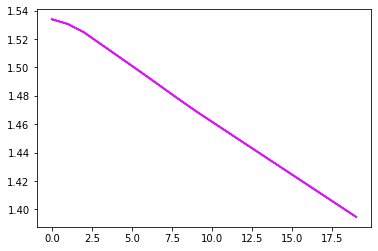

In [6]:
# Test plot of 10 arms' Whittle indices at first batch
colors = plt.cm.cool(np.linspace(0,1,10))
for i in range(10):
    plt.plot(Whittle_all_recorded[i,0,:]*1e7,color=colors[i]);

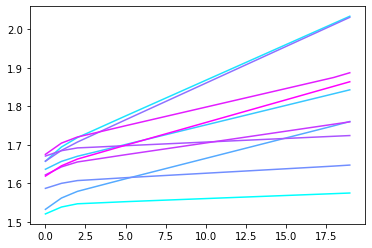

In [4]:
# Test plot of 10 arms' Whittle indices at final batch
colors = plt.cm.cool(np.linspace(0,1,10))
for i in range(10):
    plt.plot(Whittle_all_recorded[i,49,:]*1e7,color=colors[i]);

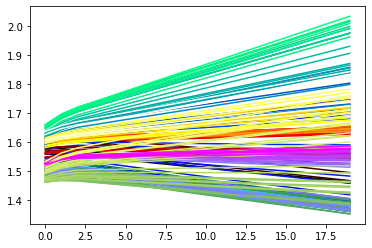

In [7]:
# Test plot of first 4 arms' Whittle indices for all batches
colors1 = plt.cm.cool(np.linspace(0,1,50))
colors2 = plt.cm.winter(np.linspace(0,1,50))
colors3 = plt.cm.hot(np.linspace(0,1,50))
colors4 = plt.cm.summer(np.linspace(0,1,50))
for i in range(50):
    plt.plot(Whittle_all_recorded[0,i,:]*1e7,color=colors1[i])
    plt.plot(Whittle_all_recorded[1,i,:]*1e7,color=colors2[i])
    plt.plot(Whittle_all_recorded[2,i,:]*1e7,color=colors3[i])
    plt.plot(Whittle_all_recorded[3,i,:]*1e7,color=colors4[i])

# Evaluation

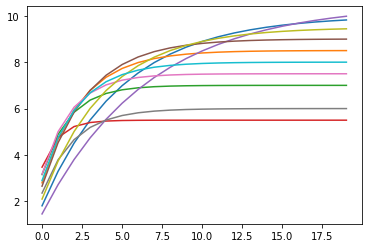

In [8]:
# Generate and plot Reward distribution
arm = 0
Reward = np.zeros([20,10])
for condition in ['A','B','C','D','E','F','G','H','I','J']:
    if condition == "A":
        theta0 = 10
        theta1 = 0.2
    elif condition == "B":
        theta0 = 8.5
        theta1 = 0.4
    elif condition == "C":
        theta0 = 7
        theta1 = 0.6
    elif condition == "D":
        theta0 = 5.5
        theta1 = 1
    elif condition == "E":
        theta0 = 10.5
        theta1 = 0.15
    elif condition == "F":
        theta0 = 9
        theta1 = 0.35
    elif condition == "G":
        theta0 = 7.5
        theta1 = 0.55
    elif condition == "H":
        theta0 = 6
        theta1 = 0.5
    elif condition == "I":
        theta0 = 9.5
        theta1 = 0.25
    elif condition == "J":
        theta0 = 8
        theta1 = 0.45
    else:
        print("Invalid")
    
    for i in range(20):
        s1 = (i+1) / 20
        Reward[i,arm] = theta0 * (1 - np.exp(-theta1 * s1 * 20))
    
    arm += 1

plt.plot(Reward);

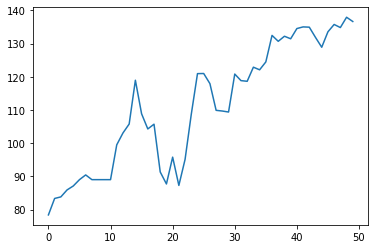

In [14]:
# TDR for (10,1)
numberOfSeeds = 50 # generate 50 samples from random distribution
num_arm = 10
s = np.random.randint(20, size=[numberOfSeeds,num_arm]) 
Total_dicounted_reward = np.zeros(NumBatch)
std = 1e-12
for b in range(NumBatch):
    Discounted_Reward = np.zeros(numberOfSeeds)
    for i in range(numberOfSeeds):
        log=np.zeros([Timesteps,num_arm])
        ss = copy.deepcopy(s[i,:])
        for t in range(Timesteps):
            fs=[]
            for m in range(num_arm):
                fs.append(Whittle_all_recorded[m,b,ss[m]])
            fs_actual = fs+np.random.normal(0,std,num_arm)
            for arm in range(num_arm):
                if fs_actual[arm]==np.max(fs_actual): # Select arm with largest Whittle index
                    Discounted_Reward[i] += Reward[ss[arm],arm]*np.power(beta,t-1)
                    ss[arm]=1
                    log[t,arm]=1
                elif ss[arm]<19:
                    ss[arm]=ss[arm]+1           
            
    Total_dicounted_reward[b]=np.mean(Discounted_Reward)

plt.plot(Total_dicounted_reward)

In [15]:
log

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [16]:
np.sum(log,axis=0)

array([0., 5., 2., 1., 0., 4., 0., 1., 4., 3.])